In [16]:
import random
import ujson
from rlagents import MCAgent, QLAgent, benchmark
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

## TuringLearner
Can a Reinforcement Agent learn to perform right shift using a Turing Machine?

Turing machines represent a powerful class of computing machines. The Human input to those machines is that part of the machine which contains it's 'programming'. Namely the part which says what action to take.

In [2]:
from rlagents import __version__
__version__

(0, 0, 11)

In [3]:
actions = ['<', '>', 'r', 'w', 'stop']
agent_list = [MCAgent(actions), QLAgent(actions)]
print(agent_list)

[<rlagents.mc.MCAgent object at 0x7f3651833208>, <QLearner>]


In [4]:
class TuringWorld:
    def __init__(self, iogen):
        self.iogen = iogen
        self.reset()
    
    def reset(self):
        self.inp, self.out = self.iogen()
        self.out_tape = list(self.out)
        self.tape = list(self.inp)
        self.rlimit = len(self.tape) - 1
        self.head = 0
        self.cache = '0'
        return [self.tape[self.head], self.cache, self.head]
    
    def copy(self):
        t = TuringWorld(self.iogen)
        t.tape = self.tape
        t.head = self.head
        t.cache = self.cache
        t.inp, t.out = self.inp, self.out
        t.out_tape = self.out_tape
        return t

    def step(self, act):
        done = False
        if act == '<':
            self.head = max(0, self.head - 1)
        elif act == '>':
            self.head = min(self.head + 1, self.rlimit)
        elif act == 'r':
            self.cache = self.tape[self.head]
        elif act == 'w':
            self.tape[self.head] = self.cache
        elif act == 'stop':
            done = True
        rew = 1 if self.tape == self.out_tape else 0
        return [self.tape[self.head], self.cache, self.head], rew ,done, None

In [5]:
def divbytwogen():
    a = int(random.random()*10)
    b = a // 2
    a, b = bin(a)[2:], bin(b)[2:]
    return a, b
world_list = [TuringWorld(divbytwogen)]

## Running bench

In [9]:
paths = benchmark(agent_list, world_list, 5000, None, 500)

DataDir Exists
Building Dispatch list...
Running experiments...


100%|██████████| 200/200 [02:50<00:00,  1.55it/s]

Experiments completed...


In [10]:
data = []
for p in tqdm(paths):
    with open(p, 'r') as fl:
        d = ujson.load(fl)
        data.extend(d)

100%|██████████| 200/200 [00:01<00:00, 109.97it/s]


## Result Plotting

In [28]:
df = pd.DataFrame(data, columns=['runid', 'agent', 'world', 'ep', 'rew', 'trial'])
df.ep = df.ep.astype(int)
df.rew = df.rew.astype(float)
df.trial = df.trial.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
runid    1000000 non-null object
agent    1000000 non-null object
world    1000000 non-null object
ep       1000000 non-null int64
rew      1000000 non-null float64
trial    1000000 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 45.8+ MB


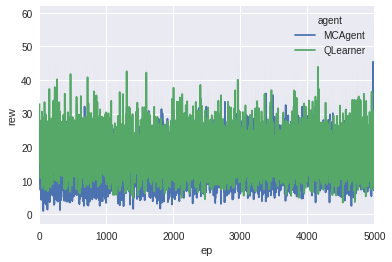

In [32]:
sns.tsplot(df, time='ep', value='rew', unit='trial', condition='agent')

In [ ]:
!rm -rf D